# MiBiReMo Example 2: BTEX dissolution modelling

This notebook models uses MiBiReMo to simulate the dissolution of benzene and ethylbenzene from NAPL phase into aqueous phase.

### Import libraries

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import mibiremo
from importlib.resources import files

### Simulation settings
In this section, the main parameters for the simulation are defined, including the initial conditions, reaction parameters, and simulation options.
The database used here is `mibirem.dat`, which contains the necessary reaction kinetics fot the BTEX compounds. In this simulation we use only one cell, like having a single well-mixed batch reactor.


In [ ]:
database_path = str(files("mibiremo").joinpath("database/mibirem.dat"))  # Database path
n_cells = 1  # Number of model cells
n_threads = 4  # Threads for calculation (-1 for all CPUs)
pqi_file = "pqi/ex2_BTEX_dissolution.pqi"  # Phreeqc input file

# Unit settings
unit_solution = 2  # 1: mg/L; 2: mol/L; 3: kg/kgs
units = 1  # 0: mol/L cell; 1: mol/L water; 2: mol/L rock

# Physical properties
porosity = 1.0  # Porosity
saturation = 1.0  # Saturation

# Time settings
sim_duration = 7.0  # Simulation duration (days)
n_steps = 100  # Number of time steps

### Initialize PhreeqcRM and run initial setup

Here we initialize the PhreeqcRM object and we run an initial simulation to retrieve information about the components and species involved in the simulation. This step is needed to ensure that the system is initialized correctly before proceeding with the titration simulation. After this step, we can get the list of the components and species in the system.

In [26]:
# Initialize PhreeqcRM
phr = mibiremo.PhreeqcRM()
phr.create(nxyz=n_cells, n_threads=n_threads)
phr.initialize_phreeqc(database_path, unit_solution, units, porosity, saturation)

# Prepare the initial conditions
# Use SOLUTION 1 and KINETICS 1, disable all model features (-1)
ic = [1, -1, -1, -1, -1, -1, 1]

# Repeat for all other cells (row-wise)
ic = np.tile(ic, (n_cells, 1))

phr.run_initial_from_file(pqi_file, ic)

# Show components and species
print("Components:")
for comp in phr.components:
    print(f"  {comp}")
print("\nSpecies:")
for spec in phr.species:
    print(f"  {spec}")

Components:
  H
  O
  Charge
  Benz
  Benznapl
  Ethyl
  Ethylnapl

Species:
  Benz
  Benznapl
  Ethyl
  Ethylnapl
  H+
  H2
  H2O
  O2
  OH-


### Prepare concentration vectors and time-stepping setup
In this section, we prepare the concentration vectors for the components and species involved in the simulation. We also set up the time-stepping parameters, including the time step size and the time vector for the simulation.

In [27]:
# Get components and species
components = phr.components
species = phr.species
n_comps = len(phr.components)
n_species = len(phr.species)

# Get initial concentrations
cc = np.zeros(n_cells * n_comps, dtype=np.float64)
cs = np.zeros(n_cells * n_species, dtype=np.float64)
phr.rm_get_concentrations(cc)
phr.rm_get_species_concentrations(cs)

# Time step setup
dt = sim_duration / n_steps * 24 * 3600.0  # Convert days to seconds

# Initialize results storage
time_vector = np.zeros(n_steps)
component_headings = ["Benz", "Benznapl", "Ethyl", "Ethylnapl"]
concentration_results = np.zeros((n_steps, len(component_headings)))

# Create component mapping
component_map = np.zeros(len(component_headings), dtype=np.int32)
for i, comp in enumerate(component_headings):
    component_map[i] = np.where(components == comp)[0][0]

# Store initial concentrations
concentration_results[0, :] = cc[component_map]

### Main simulation loop
The time loop iterates over the defined time vector, saving the concentrations of the components and species at each time step in the `concentration_results` array.

In [28]:
start_time = time.time()
for step in range(1, n_steps):
    current_time = step * dt
    time_vector[step] = current_time

    # Run simulation step
    phr.rm_set_time(current_time)
    phr.rm_set_time_step(dt)
    status = phr.rm_run_cells()

    # Store results
    status = phr.rm_get_concentrations(cc)
    concentration_results[step, :] = cc[component_map]

elapsed = time.time() - start_time
print(f"Simulation completed in {elapsed:.2f} seconds")

Simulation completed in 0.04 seconds


### Plot results

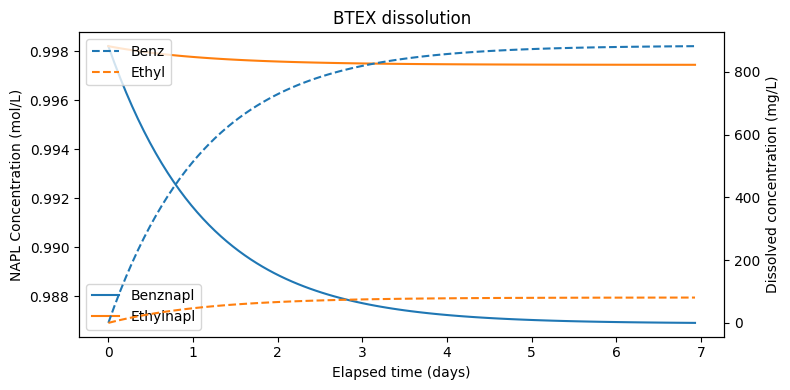

In [29]:
plt.figure(figsize=(8, 4))

# Plot NAPL concentrations (mol/L)
plt.plot(time_vector / 86400.0, concentration_results[:, [1, 3]])
plt.xlabel("Elapsed time (days)")
plt.ylabel("NAPL Concentration (mol/L)")
plt.legend(["Benznapl", "Ethylnapl"])
plt.title("BTEX dissolution")

# Create second y-axis for dissolved concentrations (mg/L)
ax2 = plt.twinx()
dissolved_mgL = concentration_results[:, [0, 2]].copy()
dissolved_mgL[:, 0] *= 78.11 * 1000  # Benzene: mol/L to mg/L
dissolved_mgL[:, 1] *= 106.17 * 1000  # Ethylbenzene: mol/L to mg/L
ax2.plot(time_vector / 86400.0, dissolved_mgL, "--")
ax2.set_ylabel("Dissolved concentration (mg/L)")
ax2.legend(["Benz", "Ethyl"])

plt.tight_layout()
plt.show()